In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('final_manglish.csv')

# Convert Sentiment Classes to Integers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Mixed Feelings': 3, 'Not_relevant': 4}
df['Sentiment_Class'] = df['Sentiment_Class'].map(label_mapping)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    df[df['Sentiment_Class'] == label_mapping['Positive']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Negative']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Not_relevant']],
    df[df['Sentiment_Class'] == label_mapping['Mixed Feelings']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Neutral']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True)
])

# Tokenization using M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoded_data_upsampled = tokenizer(data_upsampled['commentText'].tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

# Prepare target variable
labels_upsampled = torch.tensor(data_upsampled['Sentiment_Class'].values)

# Split the upsampled dataset
train_indices, test_indices = train_test_split(
    np.arange(len(encoded_data_upsampled.input_ids)),
    random_state=42,
    test_size=0.2
)

train_inputs = encoded_data_upsampled.input_ids[train_indices]
test_inputs = encoded_data_upsampled.input_ids[test_indices]
train_masks = encoded_data_upsampled.attention_mask[train_indices]
test_masks = encoded_data_upsampled.attention_mask[test_indices]
train_labels = labels_upsampled[train_indices]
test_labels = labels_upsampled[test_indices]

# Create DataLoader for train and test sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

# Load pre-trained M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_mapping))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 2
best_val_loss = float('inf')
patience = 0
for epoch in range(epochs):
    # Training loop
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in progress_bar:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})

    # Validation
    model.eval()
    val_losses = []
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
            val_loss = outputs.loss.item()
            val_losses.append(val_loss)

    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {avg_val_loss:.4f}')

    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience > 2:
            print("Early stopping triggered, no improvement in test loss.")
            break

# Evaluate the model on the test set
model.eval()
test_predictions = []
test_labels_flattened = test_labels.flatten().long()
with torch.no_grad():
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
        outputs = model(inputs, attention_mask=masks)
        _, preds = torch.max(outputs.logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())

# Print classification report
print("Classification Report:")
print(classification_report(test_labels_flattened.cpu().numpy(), test_predictions, target_names=label_mapping.keys()))

# Save the model
output_dir = './mbert_sentiment_model'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'tokenizer': tokenizer,
    'label_mapping': label_mapping
}, output_dir)

print("Model saved successfully at:", output_dir)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Test Loss: 0.6149, Test Accuracy: 0.7784


Epoch 2/2, Test Loss: 0.3687, Test Accuracy: 0.8766


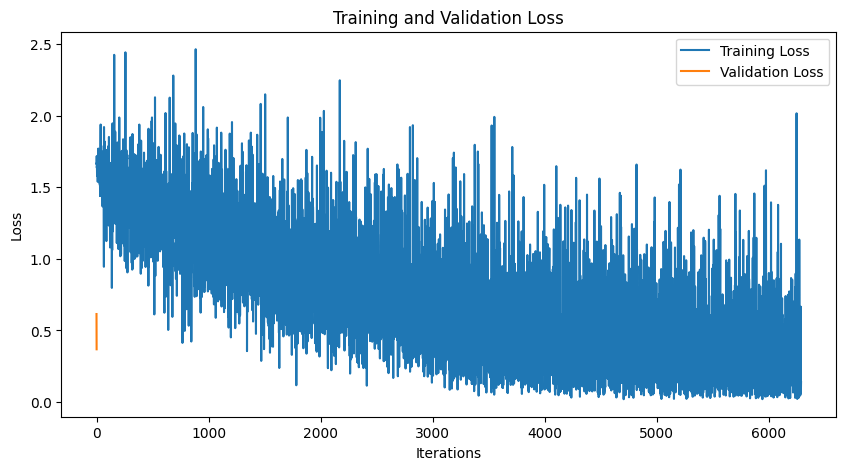

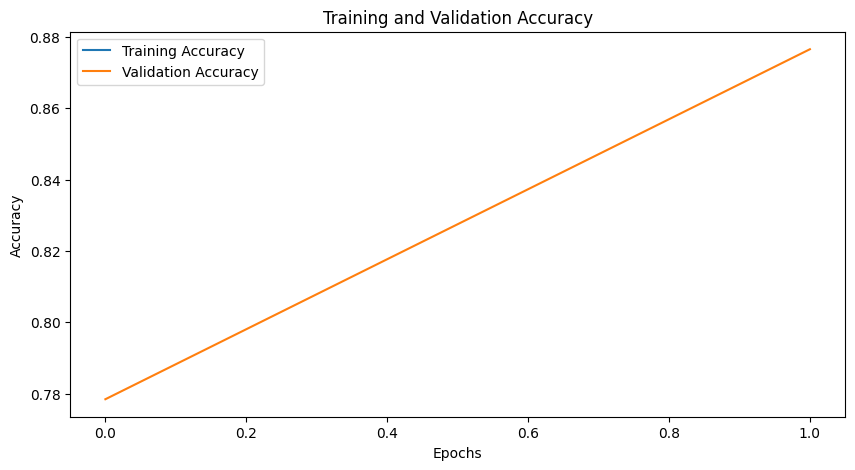

Model saved successfully at: ./mbert_sentiment_model


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('final_manglish.csv')

# Convert Sentiment Classes to Integers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Mixed Feelings': 3, 'Not_relevant': 4}
df['Sentiment_Class'] = df['Sentiment_Class'].map(label_mapping)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    df[df['Sentiment_Class'] == label_mapping['Positive']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Negative']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Not_relevant']],
    df[df['Sentiment_Class'] == label_mapping['Mixed Feelings']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Neutral']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True)
])

# Tokenization using M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoded_data_upsampled = tokenizer(data_upsampled['commentText'].tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

# Prepare target variable
labels_upsampled = torch.tensor(data_upsampled['Sentiment_Class'].values)

# Split the upsampled dataset
train_indices, test_indices = train_test_split(
    np.arange(len(encoded_data_upsampled.input_ids)),
    random_state=42,
    test_size=0.2
)

train_inputs = encoded_data_upsampled.input_ids[train_indices]
test_inputs = encoded_data_upsampled.input_ids[test_indices]
train_masks = encoded_data_upsampled.attention_mask[train_indices]
test_masks = encoded_data_upsampled.attention_mask[test_indices]
train_labels = labels_upsampled[train_indices]
test_labels = labels_upsampled[test_indices]

# Create DataLoader for train and test sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

# Load pre-trained M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_mapping))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 2
best_val_loss = float('inf')
patience = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training loop
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in progress_bar:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses_epoch = []
    val_preds_epoch = []
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
            val_loss = outputs.loss.item()
            val_losses_epoch.append(val_loss)
            _, val_preds = torch.max(outputs.logits, dim=1)
            val_preds_epoch.extend(val_preds.cpu().numpy())

    avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_acc = accuracy_score(test_labels.cpu().numpy(), val_preds_epoch)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_acc:.4f}')

    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience > 2:
            print("Early stopping triggered, no improvement in test loss.")
            break

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save the model
output_dir = './mbert_sentiment_model'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'tokenizer': tokenizer,
    'label_mapping': label_mapping
}, output_dir)

print("Model saved successfully at:", output_dir)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Test Loss: 0.9271, Test Accuracy: 0.6424


Epoch 2/2, Test Loss: 0.5888, Test Accuracy: 0.7880


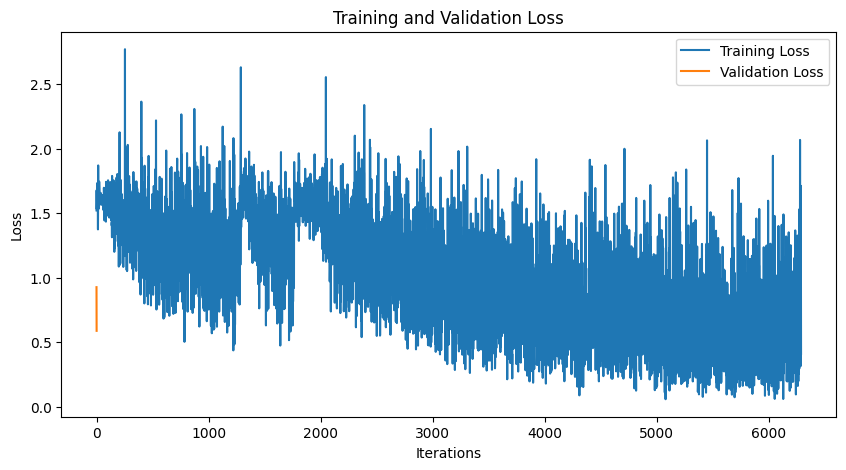

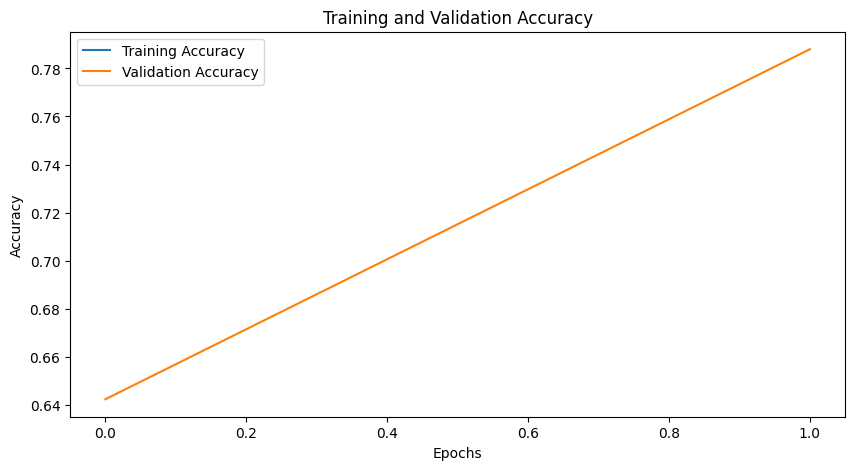

Model saved successfully at: ./mbert_sentiment_model


Classification Report:
                precision    recall  f1-score   support

      Negative       0.73      0.75      0.74      1317
       Neutral       0.83      0.83      0.83      1256
      Positive       0.78      0.79      0.78      1246
Mixed Feelings       0.88      0.97      0.92      1215
  Not_relevant       0.71      0.62      0.66      1253

      accuracy                           0.79      6287
     macro avg       0.79      0.79      0.79      6287
  weighted avg       0.78      0.79      0.79      6287



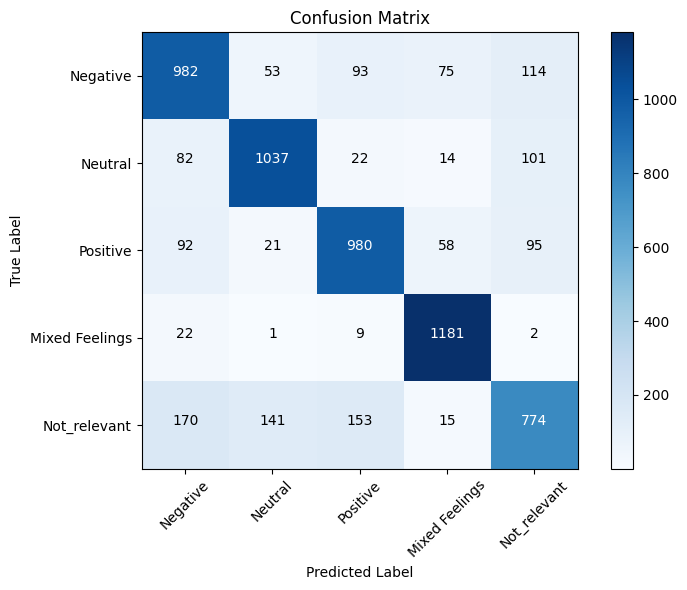

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('final_manglish.csv')

# Convert Sentiment Classes to Integers
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Mixed Feelings': 3, 'Not_relevant': 4}
df['Sentiment_Class'] = df['Sentiment_Class'].map(label_mapping)

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    df[df['Sentiment_Class'] == label_mapping['Positive']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Negative']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Not_relevant']],
    df[df['Sentiment_Class'] == label_mapping['Mixed Feelings']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True),
    df[df['Sentiment_Class'] == label_mapping['Neutral']].sample(n=len(df[df['Sentiment_Class'] == label_mapping['Not_relevant']]), replace=True)
])

# Tokenization using M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
encoded_data_upsampled = tokenizer(data_upsampled['commentText'].tolist(), padding=True, truncation=True, max_length=256, return_tensors='pt')

# Prepare target variable
labels_upsampled = torch.tensor(data_upsampled['Sentiment_Class'].values)

# Split the upsampled dataset
train_indices, test_indices = train_test_split(
    np.arange(len(encoded_data_upsampled.input_ids)),
    random_state=42,
    test_size=0.2
)

train_inputs = encoded_data_upsampled.input_ids[train_indices]
test_inputs = encoded_data_upsampled.input_ids[test_indices]
train_masks = encoded_data_upsampled.attention_mask[train_indices]
test_masks = encoded_data_upsampled.attention_mask[test_indices]
train_labels = labels_upsampled[train_indices]
test_labels = labels_upsampled[test_indices]

# Create DataLoader for train and test sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

# Load pre-trained M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(label_mapping))

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 2
best_val_loss = float('inf')
patience = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training loop
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)
    for batch in progress_bar:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'training_loss': f'{loss.item():.3f}'})
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses_epoch = []
    val_preds_epoch = []
    for batch in test_dataloader:
        inputs, masks, labels = batch
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks, labels=labels)
            val_loss = outputs.loss.item()
            val_losses_epoch.append(val_loss)
            _, val_preds = torch.max(outputs.logits, dim=1)
            val_preds_epoch.extend(val_preds.cpu().numpy())

    avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
    val_acc = accuracy_score(test_labels.cpu().numpy(), val_preds_epoch)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_acc:.4f}')

    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience > 2:
            print("Early stopping triggered, no improvement in test loss.")
            break

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save the model
output_dir = './mbert_sentiment_model'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'tokenizer': tokenizer,
    'label_mapping': label_mapping
}, output_dir)

print("Model saved successfully at:", output_dir)

# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predictions = []
true_labels = []

progress_bar = tqdm(test_dataloader, desc='Evaluating', leave=False)
for batch in progress_bar:
    inputs, masks, labels = batch
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=label_mapping.keys()))

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions) 
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_mapping))
plt.xticks(tick_marks, label_mapping.keys(), rotation=45)
plt.yticks(tick_marks, label_mapping.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Add numerical annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

